### Imports

In [2]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras # Importing Keras
from keras import backend as K # plaidml alias
from keras.datasets import fashion_mnist # Import the mnist dataset
from keras.layers import Input, Dense # Layers to be used for building our model
from keras.models import Model # The class used to create a model
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils # Utilities to manipulate numpy arrays
#from tensorflow import set_random_seed # Used for reproducible experiments

import gc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using plaidml.keras.backend backend.


### Data manipulation

**Task**: Given an image of handwritten digit find the digit

**Data**:
- The data are grayscale 28*28 images of fashion clothing elements
- We will use an MLP to classify them so we first need to flatten them
- The values of the inputs are in [0, 255] so we normalize them to [0, 1]

In [3]:
batch_size = 128
classes = 10
epochs = 50

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)

### Plotting results

In [4]:
def plot_history(hs, epochs, metric):
    plt.clf()
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric))
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric))
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


### Cleaning up

In [5]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


### Model creation

- We will use a Functional Model.
    - It is more flexible than the `Sequential` model but ...
    - We need to be careful with the sizes of the layers.
- The first layer should always be an `Input` layer where we specify the input of the model, e.g., the training data
- The other layers can be whatever we want and for each layer we must:
    - Define the input to the layer, i.e., another layer.
    - Define the number of units which also defines the output size.
        - The output size must be always equal to the number of units of the next layer.


In [6]:
def train_model(
        train_data,
        train_labels,
        optimizer,
        epochs,
        batch_size,
        hidden_layers,
        hidden_activation='relu',
        output_activation='softmax'):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
#    set_random_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=256,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer='uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=1,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs


### Using SGD

In [60]:
# Using SGD
optimizer = SGD(lr=0.01)

# Logistic Regression
lr_model_sgd, lr_hs_sgd = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_sgd = lr_model_sgd.evaluate(X_test, Y_test, verbose=1)
clean_up(model=lr_model_sgd)

INFO:plaidml:Opening device "metal_amd_radeon_pro_560.0"


Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 2s 45us/step - loss: 1.1800 - acc: 0.6565 - val_loss: 0.8541 - val_acc: 0.7307
Epoch 2/20
54000/54000 [==============================] - 2s 30us/step - loss: 0.7956 - acc: 0.7477 - val_loss: 0.7271 - val_acc: 0.7673
Epoch 3/20
54000/54000 [==============================] - 2s 44us/step - loss: 0.7076 - acc: 0.7756 - val_loss: 0.6686 - val_acc: 0.7802
Epoch 4/20
54000/54000 [==============================] - 2s 33us/step - loss: 0.6596 - acc: 0.7908 - val_loss: 0.6315 - val_acc: 0.7928
Epoch 5/20
54000/54000 [==============================] - 2s 33us/step - loss: 0.6278 - acc: 0.7994 - val_loss: 0.6069 - val_acc: 0.8010
Epoch 6/20
54000/54000 [==============================] - 2s 29us/step - loss: 0.6046 - acc: 0.8064 - val_loss: 0.5888 - val_acc: 0.8048
Epoch 7/20
54000/54000 [==============================] - 2s 43us/step - loss: 0.5870 - acc: 0.8113 - val_loss: 0.5721 - val_acc:

### Logistic Regression results

Train Loss     : 0.49571
Validation Loss: 0.49181
Test Loss      : 0.52299
---
Train Accuracy     : 0.83565
Validation Accuracy: 0.83067
Test Accuracy      : 0.82280


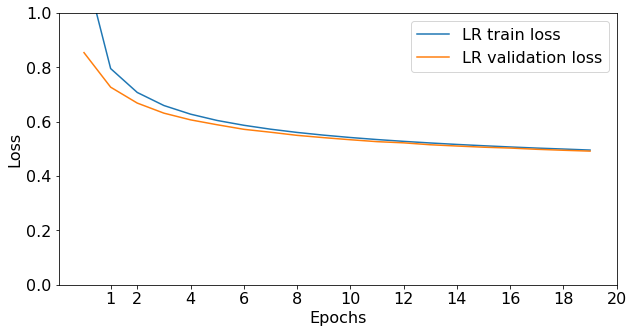

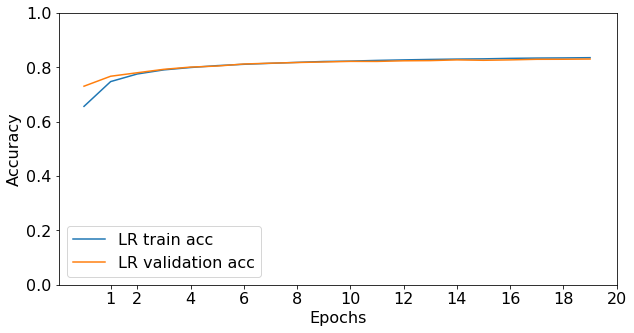

In [61]:
print("Train Loss     : {0:.5f}".format(lr_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_sgd.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_sgd.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_sgd[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='acc')

In [62]:
# Using SGD
optimizer = SGD(lr=0.01)

# MLP
mlp_model_sgd, mlp_hs_sgd = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=4,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_sgd = mlp_model_sgd.evaluate(X_test, Y_test, verbose=1)
clean_up(model=mlp_model_sgd)

INFO:plaidml:Opening device "metal_amd_radeon_pro_560.0"


Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 3s 50us/step - loss: 1.6566 - acc: 0.4725 - val_loss: 0.9361 - val_acc: 0.6598
Epoch 2/20
54000/54000 [==============================] - 2s 42us/step - loss: 0.8034 - acc: 0.6963 - val_loss: 0.6892 - val_acc: 0.7518
Epoch 3/20
54000/54000 [==============================] - 2s 42us/step - loss: 0.6610 - acc: 0.7599 - val_loss: 0.5980 - val_acc: 0.7890
Epoch 4/20
54000/54000 [==============================] - 2s 42us/step - loss: 0.5861 - acc: 0.7914 - val_loss: 0.5655 - val_acc: 0.8060
Epoch 5/20
54000/54000 [==============================] - 2s 42us/step - loss: 0.5371 - acc: 0.8113 - val_loss: 0.5579 - val_acc: 0.7915
Epoch 6/20
54000/54000 [==============================] - 2s 43us/step - loss: 0.5015 - acc: 0.8251 - val_loss: 0.4795 - val_acc: 0.8313
Epoch 7/20
54000/54000 [==============================] - 2s 44us/step - loss: 0.4775 - acc: 0.8318 - val_loss: 0.4763 - val_acc:

### Logistic Regression vs. MLP results

Train Loss     : 0.35870
Validation Loss: 0.38036
Test Loss      : 0.40652
---
Train Accuracy     : 0.87315
Validation Accuracy: 0.86617
Test Accuracy      : 0.85460


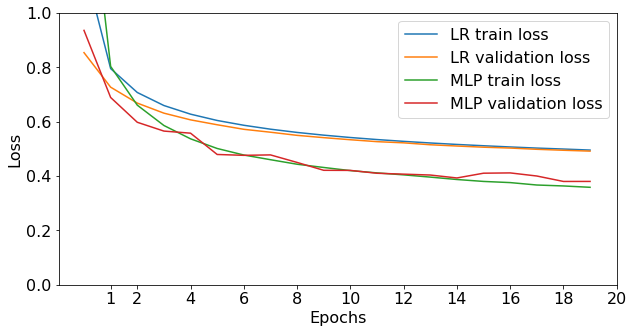

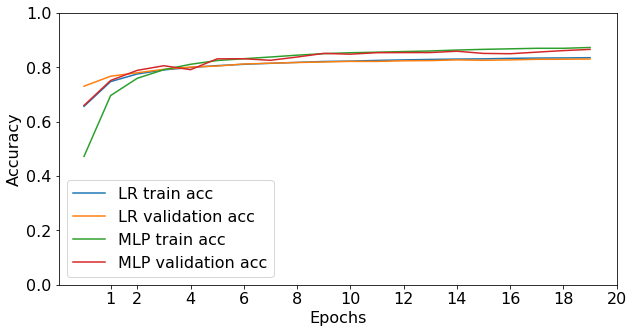

In [63]:
print("Train Loss     : {0:.5f}".format(mlp_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_sgd.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_sgd.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_sgd[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd, 'MLP': mlp_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd, 'MLP': mlp_hs_sgd}, epochs=epochs, metric='acc')

### Using Adam

In [8]:
# Using Adam
optimizer = Adam()

# Logistic Regression
lr_model_adam, lr_hs_adam = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_adam = lr_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=lr_model_adam)

INFO:plaidml:Opening device "metal_amd_radeon_pro_560.0"


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 35us/step - loss: 0.7456 - acc: 0.7563 - val_loss: 0.5474 - val_acc: 0.8163
Epoch 2/50
54000/54000 [==============================] - 2s 43us/step - loss: 0.5221 - acc: 0.8267 - val_loss: 0.4879 - val_acc: 0.8352
Epoch 3/50
54000/54000 [==============================] - 2s 34us/step - loss: 0.4797 - acc: 0.8403 - val_loss: 0.4630 - val_acc: 0.8398
Epoch 4/50
54000/54000 [==============================] - 2s 42us/step - loss: 0.4567 - acc: 0.8457 - val_loss: 0.4485 - val_acc: 0.8485
Epoch 5/50
54000/54000 [==============================] - 3s 50us/step - loss: 0.4422 - acc: 0.8494 - val_loss: 0.4357 - val_acc: 0.8492
Epoch 6/50
54000/54000 [==============================] - 2s 37us/step - loss: 0.4312 - acc: 0.8531 - val_loss: 0.4326 - val_acc: 0.8498
Epoch 7/50
54000/54000 [==============================] - 2s 46us/step - loss: 0.4236 - acc: 0.8549 - val_loss: 0.4219 - val_acc:

### Logistic Regression results

Train Loss     : 0.36170
Validation Loss: 0.40561
Test Loss      : 0.44368
---
Train Accuracy     : 0.87383
Validation Accuracy: 0.85917
Test Accuracy      : 0.84610


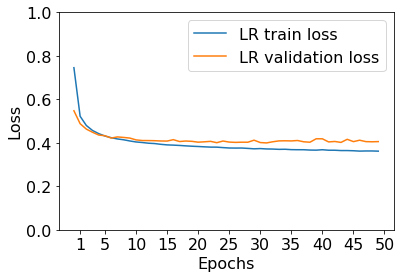

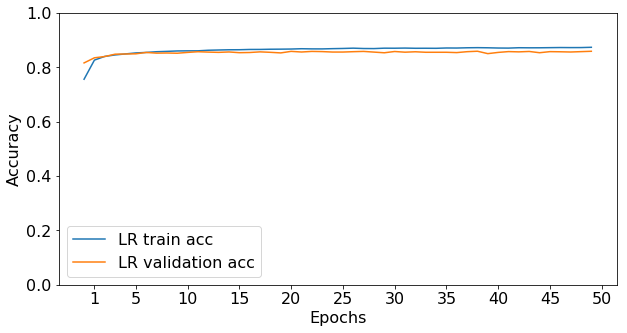

In [9]:
print("Train Loss     : {0:.5f}".format(lr_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_adam.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_adam.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_adam}, epochs=epochs, metric='acc')

In [10]:
# Using Adam
optimizer = Adam()

# MLP
mlp_model_adam, mlp_hs_adam = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=4,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_adam = mlp_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=mlp_model_adam)

INFO:plaidml:Opening device "metal_amd_radeon_pro_560.0"


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 3s 59us/step - loss: 0.5461 - acc: 0.8026 - val_loss: 0.4140 - val_acc: 0.8517
Epoch 2/50
54000/54000 [==============================] - 3s 51us/step - loss: 0.3719 - acc: 0.8643 - val_loss: 0.3801 - val_acc: 0.8652
Epoch 3/50
54000/54000 [==============================] - 3s 52us/step - loss: 0.3347 - acc: 0.8766 - val_loss: 0.3390 - val_acc: 0.8800
Epoch 4/50
54000/54000 [==============================] - 3s 52us/step - loss: 0.3109 - acc: 0.8859 - val_loss: 0.3155 - val_acc: 0.8795
Epoch 5/50
54000/54000 [==============================] - 3s 56us/step - loss: 0.2875 - acc: 0.8937 - val_loss: 0.3242 - val_acc: 0.8775
Epoch 6/50
54000/54000 [==============================] - 3s 53us/step - loss: 0.2749 - acc: 0.8989 - val_loss: 0.3234 - val_acc: 0.8860
Epoch 7/50
54000/54000 [==============================] - 3s 54us/step - loss: 0.2621 - acc: 0.9015 - val_loss: 0.3264 - val_acc:

### Logistic Regression vs. MLP results

Train Loss     : 0.06660
Validation Loss: 0.59820
Test Loss      : 0.64635
---
Train Accuracy     : 0.97404
Validation Accuracy: 0.89717
Test Accuracy      : 0.88880


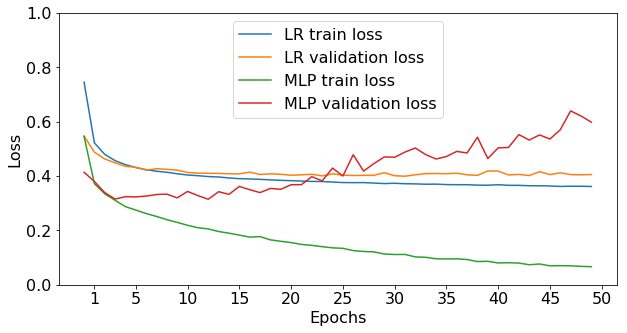

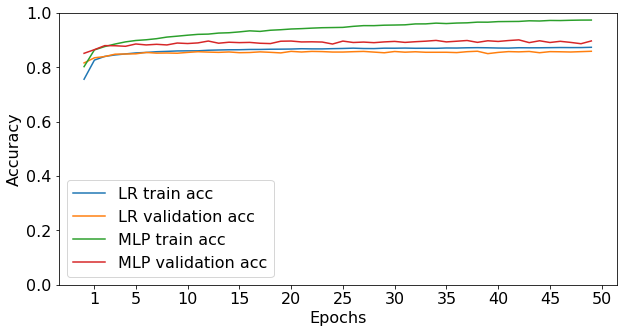

In [11]:
print("Train Loss     : {0:.5f}".format(mlp_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_adam.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_adam.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_adam, 'MLP': mlp_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_adam, 'MLP': mlp_hs_adam}, epochs=epochs, metric='acc')

In [13]:
exit()